Data Science for Linguists WiSe 2024/25 - University of Tübingen

Final Project by Nikita L. Beklemishev and Szymon T. Kossowski

*Quantifying scope and disrtribution of Slavic Short Adjectives*

Honour Code:
*We pledge that this project represents our own work. The code is ours unless flagged otherwise*

In [1]:
# data exploration and collection

In [2]:
! pip install conllu
! pip install geopandas
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.2.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
conllu==6.0.

Optional Google Drive mounting (if run in Google Colab)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import csv
import pandas as pd
import conllu
import os
import numpy as np
import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import math
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

For running the notebook on Google Colab

In [7]:
%cd 'drive/My Drive/datsciproject-beklemishev-kossowski/rawdata/corpora/'

[Errno 2] No such file or directory: 'drive/My Drive/datsciproject-beklemishev-kossowski/rawdata/corpora/'
/content


For running the notebook on desktop

In [ ]:
%cd '/datsciproject-beklemishev-kossowski/rawdata/corpora/'

In [ ]:
%ls

UD_Belarusian-HSE/  UD_Czech-PUD/       UD_Russian-SynTagRus/
UD_Croatian-SET/    UD_Polish-LFG/      UD_Russian-Taiga/
UD_Czech-CAC/       UD_Polish-PDB/      UD_Serbian-SET/
UD_Czech-CLTT/      UD_Polish-PUD/      UD_Slovenian-SSJ/
UD_Czech-FicTree/   UD_Russian-GSD/     UD_Slovenian-SST/
UD_Czech-PDT/       UD_Russian-Poetry/  UD_Ukrainian-IU/
UD_Czech-Poetry/    UD_Russian-PUD/     UD_Ukrainian-ParlaMint/


In [ ]:
# Overview of UD corpora per language
langs = dict()
langs_pd = []
for d in os.listdir():
    lang = d[3:].split('-')[0]
    langs_pd.append((lang, d))
    if lang not in langs:
        langs[lang] = [d]
    else:
        langs[lang].append(d)

In [ ]:
langs_pd = sorted(langs_pd, key=lambda x: x[0])

In [ ]:
langs_pd

[('Belarusian', 'UD_Belarusian-HSE'),
 ('Croatian', 'UD_Croatian-SET'),
 ('Czech', 'UD_Czech-PUD'),
 ('Czech', 'UD_Czech-Poetry'),
 ('Czech', 'UD_Czech-PDT'),
 ('Czech', 'UD_Czech-CLTT'),
 ('Czech', 'UD_Czech-FicTree'),
 ('Czech', 'UD_Czech-CAC'),
 ('Polish', 'UD_Polish-PUD'),
 ('Polish', 'UD_Polish-LFG'),
 ('Polish', 'UD_Polish-PDB'),
 ('Russian', 'UD_Russian-SynTagRus'),
 ('Russian', 'UD_Russian-GSD'),
 ('Russian', 'UD_Russian-Poetry'),
 ('Russian', 'UD_Russian-Taiga'),
 ('Russian', 'UD_Russian-PUD'),
 ('Serbian', 'UD_Serbian-SET'),
 ('Slovenian', 'UD_Slovenian-SSJ'),
 ('Slovenian', 'UD_Slovenian-SST'),
 ('Ukrainian', 'UD_Ukrainian-ParlaMint'),
 ('Ukrainian', 'UD_Ukrainian-IU')]

In [ ]:
df_UDreview_index = pd.MultiIndex.from_tuples(langs_pd, names=["language", "corpus"])

In [ ]:
df_UDreview = pd.DataFrame(index=df_UDreview_index, columns=['num_sentences', 'num_tokens'])

In [ ]:
### TEST
# extracting number of sents and tokens for polish
os.chdir('UD_Polish-PDB')
file_found = 0
for corpusfile in os.listdir():
    if corpusfile.endswith('train.conllu') or corpusfile.endswith('pud-ud-test.conllu'):
        file_found = 1
        with open(corpusfile, 'r', encoding='utf-8') as f:
            dat = conllu.parse(f.read())
if file_found == 0:
    print('No train.conllu file found')
os.chdir('..')

KeyboardInterrupt: 

In [ ]:
# extracting number of sents and tokens for each corpus
for lang, corpus in langs_pd:
    print(lang)
    os.chdir(corpus)
    file_found = 0
    for corpusfile in os.listdir():
        if 'poetry' not in corpusfile:
            if corpusfile.endswith('train.conllu'):
                file_found = 1
                print(corpusfile)
                with open(corpusfile, 'r', encoding='utf-8') as f:
                    training_dat = conllu.parse(f.read())
            elif corpusfile.endswith('test.conllu'):
                file_found = 1
                print(corpusfile)
                with open(corpusfile, 'r', encoding='utf-8') as f:
                    test_dat = conllu.parse(f.read())
            elif corpusfile.endswith('dev.conllu'):
                file_found = 1
                print(corpusfile)
                with open(corpusfile, 'r', encoding='utf-8') as f:
                    dev_dat = conllu.parse(f.read())
            else:
                continue
        else:
            continue
    if not file_found:
        df_UDreview.loc[(lang, corpus), 'num_sentences'] = 0
        df_UDreview.loc[(lang, corpus), 'num_tokens'] = 0
    else:
        df_UDreview.loc[(lang, corpus), 'num_sentences'] = len(training_dat) + len(test_dat) + len(dev_dat)
        df_UDreview.loc[(lang, corpus), 'num_tokens'] = sum([len(s) for s in training_dat]) + sum([len(s) for s in test_dat]) + sum([len(s) for s in dev_dat])
    os.chdir('..')

Belarusian
be_hse-ud-test.conllu
be_hse-ud-dev.conllu
be_hse-ud-train.conllu
Croatian
hr_set-ud-dev.conllu
hr_set-ud-test.conllu
hr_set-ud-train.conllu
Czech
cs_pud-ud-test.conllu
Czech
Czech
cs_pdt-ud-dev.conllu
cs_pdt-ud-test.conllu
cs_pdt-ud-train.conllu
Czech
cs_cltt-ud-dev.conllu
cs_cltt-ud-train.conllu
cs_cltt-ud-test.conllu
Czech
cs_fictree-ud-test.conllu
cs_fictree-ud-dev.conllu
cs_fictree-ud-train.conllu
Czech
cs_cac-ud-test.conllu
cs_cac-ud-dev.conllu
cs_cac-ud-train.conllu
Polish
pl_pud-ud-test.conllu
Polish
pl_lfg-ud-test.conllu
pl_lfg-ud-dev.conllu
pl_lfg-ud-train.conllu
Polish
pl_pdb-ud-test.conllu
pl_pdb-ud-dev.conllu
pl_pdb-ud-train.conllu
Russian
ru_syntagrus-ud-dev.conllu
ru_syntagrus-ud-test.conllu
ru_syntagrus-ud-train.conllu
Russian
ru_gsd-ud-dev.conllu
ru_gsd-ud-test.conllu
ru_gsd-ud-train.conllu
Russian
Russian
ru_taiga-ud-test.conllu
ru_taiga-ud-dev.conllu
ru_taiga-ud-train.conllu
Russian
ru_pud-ud-test.conllu
Serbian
sr_set-ud-dev.conllu
sr_set-ud-train.conllu


In [ ]:
df_UDreview

num_sentences num_tokens
language   corpus                                         
Belarusian UD_Belarusian-HSE              25231     305417
Croatian   UD_Croatian-SET                 9010     199409
Czech      UD_Czech-PUD                    8874     193817
           UD_Czech-Poetry                    0          0
           UD_Czech-PDT                   87907    1531825
           UD_Czech-CLTT                   1121      36039
           UD_Czech-FicTree               12760     167850
           UD_Czech-CAC                   24709     496296
Polish     UD_Polish-PUD                  25081     503809
           UD_Polish-LFG                  17246     130967
           UD_Polish-PDB                  22152     352473
Russian    UD_Russian-SynTagRus           87336    1517881
           UD_Russian-GSD                  5030      97994
           UD_Russian-Poetry                  0          0
           UD_Russian-Taiga               17872     197001
           UD_Russian-PUD                 17991     206082
Serbian    UD_Serbian-SET                  4384      97673
Slovenian  UD_Slovenian-SSJ               13435     267097
           UD_Slovenian-SST                6108      98393
Ukrainian  UD_Ukrainian-ParlaMint          3433      51997
           UD_Ukrainian-IU                 7092     123032

In [ ]:
df_bylanguage = df_UDreview.groupby(level=0).sum()

In [ ]:
df_bylanguage.sort_values(by='num_tokens', ascending=False)

,num_sentences,num_tokens
language,,
Czech,135371,2425827
Russian,128229,2018958
Polish,64479,987249
Slovenian,19543,365490
Belarusian,25231,305417
Croatian,9010,199409
Ukrainian,10525,175029
Serbian,4384,97673


In [ ]:
### TEST
# extracting short adjectives from polish
# parsing a polish corpus
with open('UD_Polish-PDB/pl_pdb-ud-train.conllu', 'r', encoding='utf-8') as f:
    dat = conllu.parse(f.read())

In [ ]:
# example of filtering function
dat[0].filter(form=lambda x: x.endswith('a'))

TokenList<Mężczyzna, trzyma, spogląda, metadata={sent_id: "train-s1", text: "Mężczyzna w czapce z daszkiem trzyma w rękach kamerę i spogląda przez obiektyw.", orig_file_sentence: "CDScorpus_1171_A#118"}>

In [ ]:
# example of a token
dat[0][2]

{'id': 3,
 'form': 'czapce',
 'lemma': 'czapka',
 'upos': 'NOUN',
 'xpos': 'subst:sg:loc:f',
 'feats': {'Case': 'Loc', 'Gender': 'Fem', 'Number': 'Sing'},
 'head': 1,
 'deprel': 'nmod',
 'deps': [('nmod', 1)],
 'misc': None}

In [ ]:
# example filtering by feature
dat[0].filter(feats__Case='Loc')

TokenList<czapce, rękach, metadata={sent_id: "train-s1", text: "Mężczyzna w czapce z daszkiem trzyma w rękach kamerę i spogląda przez obiektyw.", orig_file_sentence: "CDScorpus_1171_A#118"}>

In [ ]:
# example filtering by multiple features
sentence3 = conllu.TokenList([
    {"id": 1, "form": "Ya"},
    {"id": 2, "form": "powinien", "feats": {"pos": "verb", "variant": "short"}},
    {"id": 3, "form": "winny", "feats": {"pos": "adj", "variant": "long"}},
    {"id": 3, "form": "winien", "feats": {"pos": "adj", "variant": "short"}},
    {"id": 4, "form": "homoseksualny", "feats": {"pos": "adj"}}
    ])

sentence3.filter(feats__variant='short', feats__pos='adj')

TokenList<winien>

In [ ]:
# example of filtering short adjectives in polish
adjs = [s.filter(feats__Variant='Short', upos='ADJ') for s in dat]
adjs = [s for s in adjs if len(s) > 0]
adjs

[TokenList<gotów, metadata={sent_id: "train-s4505", text: "Przybywam gotów na wszystko i załatwiam umowy na miejscu...", orig_file_sentence: "120-4-900000001_morph_146.49-s#3149"}>,
 TokenList<godzien, metadata={sent_id: "train-s5585", text: "- Dość szargania świętości, ten obiekt nie jest godzien nosić imię Jana Pawła II - zapowiada.", orig_file_sentence: "SuperExpress_morph_464.61-s#13598"}>,
 TokenList<gotów, metadata={sent_id: "train-s6077", text: "Kiedy "piecowy" był gotów do wykonania kolejnych obowiązków podszedł do niego pomocnik piekarza i uderzył go w twarz.", orig_file_sentence: "620-3-010000840_morph_3.21-s#11238"}>,
 TokenList<gotów, metadata={sent_id: "train-s6810", text: "Grajewski potwierdził, że jest gotów podać się do dymisji, o ile nie pojawi się szansa na przełamanie pata.", orig_file_sentence: "130-2-910000006_morph_27.61-s#3768"}>,
 TokenList<gotów, metadata={sent_id: "train-s7172", text: "Jestem gotów pójść do więzienia, po raz czwarty zresztą, ale nie powiem, sk

In [ ]:
print(f'Polish PWD corpus has {len(adjs)} sentences with short adjective forms:\n'+
      ', '.join([s[0]['form'] for s in adjs]) + '.')

Polish PWD corpus has 10 sentences with short adjective forms:
gotów, godzien, gotów, gotów, gotów, Ciekaw, Ciekaw, gotów, ciekaw, winien.


In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1dyAxgxQkabKeb8UP0iTc_TiGBwWFuZ1K/datsci2025_short_adjectives/rawdata/bancae arborerum/bancae arborerum'

In [ ]:
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1dyAxgxQkabKeb8UP0iTc_TiGBwWFuZ1K/datsci2025_short_adjectives/rawdata/bancae arborerum/bancae arborerum


In [ ]:
# os.chdir('..')
# tokens = []
# for s in dat:
#   for token in s:
#     if token['upos'] == 'ADJ' and token['feats'].get('Variant') == 'Short' or token['form'] == 'pewien'.lower() and token['upos'] == 'ADJ':
#       tokens.append(token)

# print(tokens[:10])

In [ ]:
### PREPROCESSING (beautified)

In [ ]:
def language_condition(t, l):
    '''
    adapts the extraction of short adjectives for language specific UD coding
    Args:
        t (conllu.Token) : the token to be qualified as short adjective
        l (srt) : name of the slavic language
    '''
    feats = t['feats']
    # for South Slavic, definite: Def/Ind notation is used
    if l in ['Croatian', 'Serbian', 'Slovenian']:
        return feats.get('Definite') == 'Ind'
    # for West and East Slavic variant: Short/Long notation is used,
    # for Polish pewien is an exception due to the grammar tradition
    elif l == 'Polish':
        return feats.get('Variant') == 'Short' or t['form'].lower() == 'pewien'
    else:
        return feats.get('Variant') == 'Short'

In [ ]:
def process_conllu(cfile, output_dict, lang, corp):
    '''
    Reading a corpus file and extracting the short and long adjectives to a dedicated dictionary
    Args:
        cfile (str) : corpus file name
        output_dict (dict(str: dict(str: list))) : dictionary to store all adjectives
        lang (str) : name of the language
        corp (str) : corpus folder name
    '''
    with open(cfile, 'r', encoding='utf-8') as f:
        dat = conllu.parse(f.read())  # parsing the conllu
    for s in dat:  # looping through sentences
        for token in s:  # looping through tokens
            # filtering out compounds and non-adjectives
            if token['upos'] == 'ADJ' and token.get('deprel') and token['deprel'] != 'compound'\
                and token.get('feats'):
                token_info = {'language': lang,
                                'corpus': corp,
                                'sentence_metadata': s.metadata,
                                'form': token['form'],
                                'lemma': token['lemma'],
                                'token': token}
                output_dict['all'].append(token_info)  # adding to all adjectives list
                if language_condition(token, lang):  # adding to the short adjectives list
                    output_dict['short'].append(token_info)


In [ ]:
# main loop upd
adjective_forms={'train': {'short': [], 'all': []},
                 'test': {'short': [], 'all': []},
                 'dev': {'short': [], 'all': []}}

for language, corpus in tqdm(langs_pd, desc="Loading", unit="iter"):  # taking samples from each language/corpus
  print(language)
  os.chdir(corpus)
  for corpusfile in os.listdir():  # finding the train file of each corpus
  # for one of the corpora only a test file was available
    if 'poetry' not in corpusfile:
      for sample_type in ['train', 'test', 'dev']:
        if corpusfile.endswith(sample_type + '.conllu'):
          process_conllu(corpusfile, adjective_forms[sample_type], language, corpus)
  os.chdir('..')

Loading:   0%|          | 0/21 [00:00<?, ?iter/s]

Belarusian


Loading:   5%|▍         | 1/21 [00:09<03:15,  9.76s/iter]

Croatian


Loading:  10%|▉         | 2/21 [00:12<01:48,  5.69s/iter]

Czech


Loading:  14%|█▍        | 3/21 [00:12<00:58,  3.26s/iter]

Czech
Czech


Loading:  24%|██▍       | 5/21 [01:00<03:58, 14.90s/iter]

Czech


Loading:  29%|██▊       | 6/21 [01:01<02:42, 10.83s/iter]

Czech


Loading:  33%|███▎      | 7/21 [01:06<02:09,  9.24s/iter]

Czech


Loading:  38%|███▊      | 8/21 [01:22<02:23, 11.04s/iter]

Polish


Loading:  43%|████▎     | 9/21 [01:22<01:34,  7.89s/iter]

Polish


Loading:  48%|████▊     | 10/21 [01:27<01:16,  6.97s/iter]

Polish


Loading:  52%|█████▏    | 11/21 [01:39<01:26,  8.66s/iter]

Russian


Loading:  57%|█████▋    | 12/21 [02:33<03:19, 22.14s/iter]

Russian


Loading:  62%|██████▏   | 13/21 [02:35<02:08, 16.02s/iter]

Russian
Russian


Loading:  71%|███████▏  | 15/21 [02:39<00:56,  9.47s/iter]

Russian


Loading:  76%|███████▌  | 16/21 [02:39<00:36,  7.20s/iter]

Serbian


Loading:  81%|████████  | 17/21 [02:41<00:23,  5.76s/iter]

Slovenian


Loading:  86%|████████▌ | 18/21 [02:49<00:19,  6.45s/iter]

Slovenian


Loading:  90%|█████████ | 19/21 [02:51<00:10,  5.23s/iter]

Ukrainian


Loading:  95%|█████████▌| 20/21 [02:52<00:04,  4.00s/iter]

Ukrainian


Loading: 100%|██████████| 21/21 [02:55<00:00,  8.35s/iter]


In [ ]:
# Commented out code for preprocessing (comment in if necessary)
# ### PREPROCESSING (may be edited further)
# all_training_adjectives = []
# training_short_tokens = []
# all_test_adjectives = []
# test_short_tokens = []
# all_dev_adjectives = []
# dev_short_tokens = []
# for lang, corpus in langs_pd:  # taking samples from each language/corpus
#   print(lang)
#   os.chdir(corpus)
#   for corpusfile in os.listdir():  # finding the train file of each corpus
#   # for one of the corpora only a test file was available
#     if 'poetry' not in corpusfile:
#       if corpusfile.endswith('train.conllu'):
#         with open(corpusfile, 'r', encoding='utf-8') as f:
#           dat = conllu.parse(f.read())  # parsing the conllu
#           for s in dat:  # looping through sentences
#             for token in s:  # looping through tokens
#               # filtering out compounds
#               if token.get('deprel') and token['deprel'] != 'compound':
#                 # for South Slavic, definite: Def/Ind notation is used
#                 if lang == 'Croatian' or lang == 'Serbian' or lang == 'Slovenian':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_training_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Definite') == 'Ind':
#                       training_short_tokens.append(token_info)
#                 # for West and East Slavic variant: Short/Long notation is used,
#                 # for Polish pewien is an exception due to the grammar tradition
#                 elif lang == 'Polish':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_training_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short' \
#                     or token['upos'] == 'ADJ' and token['form'] == 'pewien'.lower():
#                       training_short_tokens.append(token_info)
#                 else:
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_training_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short':
#                       training_short_tokens.append(token_info)
#       elif corpusfile.endswith('test.conllu'):
#         with open(corpusfile, 'r', encoding='utf-8') as f:
#           dat = conllu.parse(f.read())
#           for s in dat:
#             for token in s:
#               if token.get('deprel') and token['deprel'] != 'compound':
#                 if lang == 'Croatian' or lang == 'Serbian' or lang == 'Slovenian':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_test_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Definite') == 'Ind':
#                       test_short_tokens.append(token_info)
#                 elif lang == 'Polish':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_test_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short' \
#                     or token['upos'] == 'ADJ' and token['form'] == 'pewien'.lower():
#                       test_short_tokens.append(token_info)
#                 else:
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_test_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short':
#                       test_short_tokens.append(token_info)
#       elif corpusfile.endswith('dev.conllu'):
#         with open(corpusfile, 'r', encoding='utf-8') as f:
#           dat = conllu.parse(f.read())
#           for s in dat:
#             for token in s:
#               if token.get('deprel') and token['deprel'] != 'compound':
#                 if lang == 'Croatian' or lang == 'Serbian' or lang == 'Slovenian':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_dev_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Definite') == 'Ind':
#                       dev_short_tokens.append(token_info)
#                 elif lang == 'Polish':
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_dev_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short' \
#                     or token['upos'] == 'ADJ' and token['form'] == 'pewien'.lower():
#                       dev_short_tokens.append(token_info)
#                 else:
#                   if token['upos'] == 'ADJ':
#                     token_info = {'language': lang, 'corpus': corpus, 'sentence_metadata': s.metadata, 'form': token['form'], 'lemma': token['lemma'], 'token': token}
#                     all_dev_adjectives.append(token_info)
#                     if token.get('feats') and token['feats'].get('Variant') == 'Short':
#                       dev_short_tokens.append(token_info)
#     # elif corpusfile.endswith('test.conllu'):
#     #   test_short_tokens = []
#     #   with open
#   os.chdir('..')

In [ ]:
# code to be changed later, reassingning variables
training_short_tokens = adjective_forms['train']['short']
test_short_tokens = adjective_forms['test']['short']
dev_short_tokens = adjective_forms['dev']['short']
all_training_adjectives = adjective_forms['train']['all']
all_test_adjectives = adjective_forms['test']['all']
all_dev_adjectives = adjective_forms['dev']['all']

In [ ]:
# shortcut for the data we work with
short_tokens = training_short_tokens + test_short_tokens + dev_short_tokens
all_tokens = all_training_adjectives + all_test_adjectives + all_dev_adjectives

In [ ]:
# some tests with short adjective tokens

In [ ]:
print(short_tokens[:100])
print(all_tokens[:100])
print(all_tokens[:3])
print(all_tokens[-1])
print(short_tokens[-1])
# print(training_short_tokens[:100])
# print(test_short_tokens[:100])
# print(dev_short_tokens[:100])

[{'language': 'Belarusian', 'corpus': 'UD_Belarusian-HSE', 'sentence_metadata': {'sent_id': 'telegraf-2011032004-15-26-be', 'text': 'Гэта было вельмі дзіўна, і мне гэта не падабалася.', 'spelling': 'nar', 'genre': 'news'}, 'form': 'дзіўна', 'lemma': 'дзіўны', 'token': {'id': 4, 'form': 'дзіўна', 'lemma': 'дзіўны', 'upos': 'ADJ', 'xpos': 'JJH', 'feats': {'Degree': 'Pos', 'Gender': 'Neut', 'Number': 'Sing', 'Variant': 'Short'}, 'head': 0, 'deprel': 'root', 'deps': [('root', 0)], 'misc': {'SpaceAfter': 'No'}}}, {'language': 'Belarusian', 'corpus': 'UD_Belarusian-HSE', 'sentence_metadata': {'sent_id': 'telegraf-2011032004-31-38-be', 'text': 'Для мяне гэта ўсё было вельмі цікава, але я не магла зразумець, чаму яны мне пра ўсё гэта кажуць на мове сваіх, як яны гавораць, ворагаў?', 'spelling': 'nar', 'genre': 'news'}, 'form': 'цікава', 'lemma': 'цікавы', 'token': {'id': 7, 'form': 'цікава', 'lemma': 'цікавы', 'upos': 'ADJ', 'xpos': 'JJH', 'feats': {'Degree': 'Pos', 'Gender': 'Neut', 'Number':

In [ ]:
# first 100
adjs = [token['form'] for token in short_tokens]
print(adjs[:100])

all_adjs = [token['form'] for token in all_tokens]
print(all_adjs[:100])
# adjs = [token['form'] for token in training_short_tokens]
# print(adjs[:100])
# adjs = [token['form'] for token in test_short_tokens]
# print(adjs[:100])
# adjs = [token['form'] for token in dev_short_tokens]
# print(adjs[:100])

['дзіўна', 'цікава', 'немагчыма', 'важна', 'немагчыма', 'ненармальна', 'нядобра', 'сорамна', 'упэўнена', 'павінны', 'павінны', 'звязана', 'Магчыма', 'актуальны', 'важна', 'прыдатныя', 'павінны', 'вядома', 'магчыма', 'павінна', 'лёгка', 'немагчыма', 'ведама', 'павінен', 'нягож', 'вядома', 'крыўдна', 'справядліва', 'ніякавата', 'боязна', 'відавочна', 'павінен', 'Дзіўна', 'Невядома', 'ціха', 'сумна', 'дорага', 'трывожна', 'спакойна', 'немагчыма', 'згодзен', 'роўна', 'павінны', 'ціха', 'невядома', 'лёгка', 'прыгожа', 'прыгожа', 'зьмястоўна', 'даходліва', 'Ведама', 'важна', 'вядома', 'нягожа', 'добра', 'ведама', 'недастаткова', 'Вядома', 'проста', 'лёгка', 'знаёма', 'Дзіўна', 'людна', 'шумна', 'горача', 'невядома', 'багата', 'Сумна', 'сумна', 'вялік', 'стар', 'Макравата', 'Цікава', 'цяжка', 'павінен', 'патрэбна', 'магчыма', 'невядома', 'Цікава', 'добра', 'кепска', 'Магчыма', 'ЦЯЖКА', 'страшна', 'вядома', 'добра', 'соладка', 'дзіўна', 'ясна', 'немагчыма', 'павінна', 'ПАВІНЕН', 'экстрэмальны'

Exporting the preprocessed into a database

In [ ]:
os.chdir('../../..')
os.makedirs('processeddata', exist_ok=True)
os.chdir('processeddata')

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1dyAxgxQkabKeb8UP0iTc_TiGBwWFuZ1K/datsci2025_short_adjectives/processeddata'

In [ ]:
# exporting the preprocessed into a database
# short tokens for every language
with open('training_short_tokens.json', 'w', encoding='utf-8') as f:
  json.dump(training_short_tokens, f, ensure_ascii=False, indent=4)
with open('test_short_tokens.json', 'w', encoding='utf-8') as f:
  json.dump(test_short_tokens, f, ensure_ascii=False, indent=4)
with open('dev_short_tokens.json', 'w', encoding='utf-8') as f:
  json.dump(dev_short_tokens, f, ensure_ascii=False, indent=4)
# the whole
with open('all_tokens.json', 'w', encoding='utf-8') as f:
  json.dump(adjective_forms, f, ensure_ascii=False, indent=4)

In [4]:
# code for importing the json database
with open('all_tokens.json', 'r', encoding='utf-8') as f:
  adjective_forms = json.load(f)

training_short_tokens = adjective_forms['train']['short']
test_short_tokens = adjective_forms['test']['short']
dev_short_tokens = adjective_forms['dev']['short']
all_training_adjectives = adjective_forms['train']['all']
all_test_adjectives = adjective_forms['test']['all']
all_dev_adjectives = adjective_forms['dev']['all']

short_tokens = training_short_tokens + test_short_tokens + dev_short_tokens
all_tokens = all_training_adjectives + all_test_adjectives + all_dev_adjectives

for token in short_tokens:
    token['token'] = conllu.Token(token['token'])
for token in all_tokens:
    token['token'] = conllu.Token(token['token'])

FileNotFoundError: [Errno 2] No such file or directory: 'all_tokens.json'

In [ ]:
# SOME MORE TESTS

# first ten forms in each subset of adjectives
pprint.pp([t['form'] for t in short_tokens[:10]])
# pprint.pp([t['form'] for t in training_short_tokens[:10]])
# pprint.pp([t['form'] for t in test_short_tokens[:10]])
# pprint.pp([t['form'] for t in dev_short_tokens[:10]])
pprint.pp([a['form'] for a in all_tokens[:10]])

['дзіўна',
 'цікава',
 'немагчыма',
 'важна',
 'немагчыма',
 'ненармальна',
 'нядобра',
 'сорамна',
 'упэўнена',
 'павінны']
['Паўднёвая',
 'беларускую',
 'Найбуйнейшая',
 'юрыдычная',
 'Паўднёвай',
 'інвестыцыйнымі',
 'беларускай',
 'Нацыянальным',
 'прыярытэтных',
 'юрыдычнае']


In [ ]:
# making counts for short and all adjectives
freq_short_tokens = Counter([t['form'] for t in short_tokens])
freq_all_tokens = Counter([a['form'] for a in all_tokens])
# freq_tokens = Counter([t['form'] for t in training_short_tokens])
# freq_tokens = Counter([t['form'] for t in test_short_tokens])
# freq_tokens = Counter([t['form'] for t in dev_short_tokens])

In [ ]:
freq_short_tokens.most_common(10)

[('нужно', 731),
 ('должны', 496),
 ('должен', 475),
 ('možno', 397),
 ('должна', 341),
 ('невозможно', 270),
 ('должно', 254),
 ('необходимо', 244),
 ('известно', 242),
 ('rád', 228)]

In [ ]:
freq_all_tokens.most_common(10)

[('další', 1479),
 ('první', 1392),
 ('účetní', 882),
 ('nové', 839),
 ('druhé', 836),
 ('dalších', 746),
 ('České', 743),
 ('нужно', 733),
 ('jiné', 717),
 ('vlastní', 700)]

In [ ]:
# NOTE
# Russian nuzhno is a clear outlier. Like the polish / czech pewien or winien, its
# part of speech categorisation is not univerally established. Modern Russian descriptions
# would categorise nuzhno as "predikativ" or "category of state" (~ impersonal predicative expression):
# an adverb-like that can only be found as the head in subjectless copula clauses.
# Most occurrences of nuzhno correspond to that function, denoting modality with semantic subject
# in the embedded clause or marked with dative, see below and compare with other predicative adjectives.
# However, the exact delineation of the two uses of nuzhno is not uinversal. It is in spirit of
# out theory-neutral approach to keep any uses of morphologically short adjectives, regardless
# of how different its functions evolved to be.

In [ ]:
z = 0
for i in short_tokens:
  if i['form'] == 'нужно':
    pprint.pp(i['sentence_metadata']['text'])
    z += 1
  if z == 5:
    break

('А там, позади, еще два орудия, и за спиной Ищенко, как напоминание, что '
 'нужно идти туда, под обстрел, дышал разведчик, которого он взял сопровождать '
 'себя.')
('Этот отпуск всегда ему казался таким нескончаемым, таким в то же время '
 'кратким, что нужно было заранее все обдумать и выбрать место самое '
 'интересное, чтобы не ошибиться, не прогадать.')
'И на это нужно было смотреть.'
('И что она для него загадочна, как и в первую встречу, незнакома, что он, '
 'наверное, груб, туп для нее, потому что не понимает, что ей нужно, и не '
 'может сделать так, чтобы она была постоянно счастлива с ним, чтобы ей уж '
 'ничего и никого не нужно было.')
('И что она для него загадочна, как и в первую встречу, незнакома, что он, '
 'наверное, груб, туп для нее, потому что не понимает, что ей нужно, и не '
 'может сделать так, чтобы она была постоянно счастлива с ним, чтобы ей уж '
 'ничего и никого не нужно было.')


In [ ]:
# number of short adjectives per language
tl = [(t['language'], t['form']) for t in short_tokens]
ls = set(t[0] for t in tl)
lt = {l: [] for l in ls}
for t in tl:
  lt[t[0]].append(t[1])

In [ ]:
language_counts = {l: len(lt[l]) for l in lt}
pprint.pp(language_counts)

{'Slovenian': 2269,
 'Czech': 17413,
 'Ukrainian': 25,
 'Serbian': 677,
 'Croatian': 1452,
 'Belarusian': 690,
 'Polish': 31,
 'Russian': 15058}


In [ ]:
# top 5 short adjectives per language
language_forms = {l: Counter(lt[l]) for l in lt}

In [ ]:
for l in language_forms:
  print(l)
  pprint.pp(language_forms[l].most_common(5))

Slovenian
[('sam', 105), ('velik', 54), ('dober', 47), ('drug', 36), ('lep', 33)]
Czech
[('možno', 397), ('rád', 228), ('nutno', 198), ('řečeno', 171), ('známo', 120)]
Ukrainian
[('повинен', 11), ('здатен', 4), ('згоден', 4), ('годен', 2), ('винен', 2)]
Serbian
[('važan', 20), ('održan', 15), ('dobar', 10), ('poznat', 9), ('otvoren', 9)]
Croatian
[('velik', 31), ('sam', 26), ('dobar', 20), ('važan', 17), ('poznat', 16)]
Belarusian
[('вядома', 74),
 ('павінны', 39),
 ('магчыма', 39),
 ('павінна', 29),
 ('важна', 27)]
Polish
[('pewien', 15), ('gotów', 8), ('Ciekaw', 3), ('ciekaw', 2), ('winien', 2)]
Russian
[('нужно', 731),
 ('должны', 496),
 ('должен', 475),
 ('должна', 341),
 ('невозможно', 270)]


In [ ]:
# observation: words similar to russian "category of state" nuzhno are in most frequent for Czech
# Polish winien, powinien, ukr. повинен, bel. павiнны/на might deserve the same scruitiny (@Szymon)
# sam for south slavic also raises some questions

In [ ]:
# top 5 syntactic functions of short adjectives per language
lft = {l: [] for l in ls}
for t in short_tokens:
  lft[t['language']].append(t['token']['deprel'])

In [ ]:
language_relations = {l: Counter(lft[l]) for l in lft}

In [ ]:
for l in language_relations:
  print(l)
  pprint.pp(language_relations[l].most_common(5))

Slovenian
[('amod', 984), ('root', 455), ('conj', 235), ('acl', 120), ('advcl', 108)]
Czech
[('root', 7220),
 ('conj', 2311),
 ('ccomp', 1837),
 ('amod', 1661),
 ('xcomp', 1049)]
Ukrainian
[('root', 14), ('ccomp', 3), ('acl:relcl', 3), ('conj', 2), ('_', 1)]
Serbian
[('amod', 239), ('root', 172), ('acl', 101), ('conj', 53), ('ccomp', 47)]
Croatian
[('amod', 546), ('root', 353), ('acl', 177), ('conj', 148), ('ccomp', 69)]
Belarusian
[('root', 341),
 ('parataxis', 93),
 ('conj', 85),
 ('xcomp', 33),
 ('acl:relcl', 24)]
Polish
[('root', 13),
 ('conj', 6),
 ('advcl', 3),
 ('parataxis:obj', 3),
 ('ccomp:obj', 2)]
Russian
[('root', 7925),
 ('conj', 2424),
 ('parataxis', 1136),
 ('ccomp', 855),
 ('obl', 768)]


In [ ]:
# exploration continues: gender distribution per language
df_gender = pd.DataFrame(np.zeros((4, 5)), index=['Sing', 'Plur', 'Dual', 'any'], columns=['Masc', 'Fem', 'Neut', 'non-masc', 'any'])
for l in ls:
    for col in df_gender.columns:
        df_gender[col].values[:] = 0
    print('\n'+l)
    for t in short_tokens:
        if t['language'] == l:
            if t['token']['feats'].get('Gender') in df_gender.columns:
                df_gender.loc[t['token']['feats']['Number'], t['token']['feats']['Gender']] += 1
            elif t['token']['feats'].get('Gender') == 'Fem,Neut':
                if t['token']['feats'].get('Number') == 'Plur,Sing':
                    df_gender.loc['any', 'non-masc'] += 1
                else:
                    df_gender.loc[t['token']['feats']['Number'], 'non-masc'] += 1
            elif t['token']['feats'].get('Number') == 'Plur':
                df_gender.loc['Plur', 'any'] += 1
            else:
                df_gender.loc['Sing', 'Masc'] += 1
    display(df_gender)


Slovenian


,Masc,Fem,Neut,non-masc,any
Sing,2269.0,0.0,0.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,0.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Czech


,Masc,Fem,Neut,non-masc,any
Sing,5096.0,149.0,3790.0,0.0,0.0
Plur,1322.0,30.0,4.0,0.0,3143.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,3879.0,0.0



Ukrainian


,Masc,Fem,Neut,non-masc,any
Sing,25.0,0.0,0.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,0.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Serbian


,Masc,Fem,Neut,non-masc,any
Sing,676.0,0.0,1.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,0.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Croatian


,Masc,Fem,Neut,non-masc,any
Sing,1437.0,0.0,15.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,0.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Belarusian


,Masc,Fem,Neut,non-masc,any
Sing,51.0,37.0,556.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,46.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Polish


,Masc,Fem,Neut,non-masc,any
Sing,31.0,0.0,0.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,0.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0



Russian


,Masc,Fem,Neut,non-masc,any
Sing,2884.0,1936.0,7447.0,0.0,0.0
Plur,0.0,0.0,0.0,0.0,2791.0
Dual,0.0,0.0,0.0,0.0,0.0
any,0.0,0.0,0.0,0.0,0.0


In [ ]:
short_tokens[0]

{'language': 'Belarusian',
 'corpus': 'UD_Belarusian-HSE',
 'sentence_metadata': {'sent_id': 'telegraf-2011032004-15-26-be',
  'text': 'Гэта было вельмі дзіўна, і мне гэта не падабалася.',
  'spelling': 'nar',
  'genre': 'news'},
 'form': 'дзіўна',
 'lemma': 'дзіўны',
 'token': {'id': 4,
  'form': 'дзіўна',
  'lemma': 'дзіўны',
  'upos': 'ADJ',
  'xpos': 'JJH',
  'feats': {'Degree': 'Pos',
   'Gender': 'Neut',
   'Number': 'Sing',
   'Variant': 'Short'},
  'head': 0,
  'deprel': 'root',
  'deps': [('root', 0)],
  'misc': {'SpaceAfter': 'No'}}}

In [ ]:
z = 0
f = 0
for i in short_tokens:
    if i['language'] == 'Belarusian' and i['token']['feats'].get('Gender') == 'Neut':
        if 'гэта'in i['sentence_metadata']['text'].lower():
            f += 1
        z += 1
print(f'among {z} belarusian neutral short adjectives, {f} have "гэта" in that sentence')

among 556 belarusian neutral short adjectives, 81 have "гэта" in that sentence


In [ ]:
# Let's compare most frequent masculine adjectives for slovenian
def get_language_adj_frequencies(lang, short_adj, all_adj,
                                 long_condition=lambda x: x.get('Definite') and x['Definite']=='Def'):
    '''
    makes a data frame with all adjective lemmas as index and their frequencies in
    short and long forms for a given language

    Args:
    lang (tuple of str) : tuple of names of the language
    short_adj (list of the form above) : list of short adjectives
    all_adj (list of the form above) : list of all adjectives
    long_condition (function) : to determine if features of the token correspond to long adjectives in the language
    '''
    short_lang = [t for t in short_adj if t['language'] in lang]
    long_lang = [t for t in all_adj if t['language'] in lang and long_condition(t['token']['feats'])]
    lshort_lang = [t['lemma'] for t in short_lang]
    llong_lang = [t['lemma'] for t in long_lang]
    short_counts = Counter(lshort_lang)
    long_counts = Counter(llong_lang)
    lemmas = sorted(list(set(llong_lang + lshort_lang)))
    df_lang = pd.DataFrame(np.zeros((len(lemmas), 2), int), columns=['short_count', 'long_count'])
    df_lang.index = lemmas
    df_lang.index.name = 'lemma'
    for l in lemmas:
        df_lang.loc[l, 'short_count'] = short_counts.get(l, 0)
        df_lang.loc[l, 'long_count'] = long_counts.get(l, 0)
    df_lang.sort_values(by='short_count', inplace=True)
    df_lang.replace(0, np.nan, inplace=True)
    df_lang.dropna(inplace=True)
    df_lang += 1.0
    return df_lang

In [ ]:
### AI CODE WARNING
def plot_adjective_comparison(df,
                              short_col='short_count',
                              long_col='long_count',
                              title="Does the long form appear often when a short form appears often?\n"
                                    "The data was Laplace-smoothed and log-transformed, only adjectives appearing in both forms included",
                              xlabel="Adjective's frequency in short form",
                              ylabel="Adjective's frequency in long form",
                              num_xticks=20,
                              color='#8A2BE2'):
    """
    Creates a log-log regression plot of adjective frequencies with overlapping points aggregated as clouds.

    Parameters:
      - df: Pandas DataFrame with numerical data. The DataFrame index will be used for x-axis labels.
      - short_col: Column name in `df` for the short form frequency.
      - long_col: Column name in `df` for the long form frequency.
      - title: Title string for the plot (supports multi-line text).
      - xlabel: Label for the x-axis.
      - ylabel: Label for the y-axis.
      - num_xticks: Number of x-axis ticks desired. Ticks are determined by log-distance, so only one adjective is shown per tick.
      - color: Color code used for plotting.

    Returns:
      - ax: The matplotlib Axes object for further customization if needed.
    """
    # Ensure the seaborn theme uses a serif font
    sns.set_theme(style="whitegrid", rc={'font.family': 'serif'})

    # Create a figure for the plot
    plt.figure(figsize=(12, 6))

    # Plot the regression line first (without scatter) so it doesn't get obscured.
    ax = sns.regplot(x=short_col, y=long_col, data=df,
                     scatter=False,
                     line_kws={'color': color, 'lw': 3})

    # Aggregate overlapping datapoints (group by the specified columns)
    df_grouped = df.groupby([short_col, long_col]).size().reset_index(name='count')

    # Overlay the aggregated scatter plot: larger markers reflect more overlapping points.
    sns.scatterplot(x=short_col, y=long_col, data=df_grouped,
                    size='count', sizes=(50, 400),  # Adjust sizes as needed
                    color=color, alpha=0.9, ax=ax, legend=False)

    # Set log transformation for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    # --- Customizing the Y-axis ticks ---
    # Compute logarithmically spaced tick positions for the y-axis based on the data range.
    y_min = df[long_col].min()
    y_max = df[long_col].max()
    yticks = np.logspace(np.log10(y_min), np.log10(y_max), num=5)
    ax.yaxis.set_major_locator(FixedLocator(yticks))
    # Format ticks to show absolute (plain number) frequencies.
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))

    # --- Customizing the X-axis ticks based on log-distance rather than rank ---
    x_min = df[short_col].min()
    x_max = df[short_col].max()
    desired_ticks = np.logspace(np.log10(x_min), np.log10(x_max), num=num_xticks)

    # For each desired tick, find the DataFrame index (adjective) of the row whose short_count is closest.
    def find_closest_label(tick_value):
        # Calculate absolute differences between the tick value and all x values
        diffs = np.abs(df[short_col] - tick_value)
        # Return the index label corresponding to the smallest difference
        return diffs.idxmin()

    tick_labels = [find_closest_label(tv) for tv in desired_ticks]
    # Use the corresponding short_count values as the tick positions.
    tick_positions = [df.loc[label, short_col] for label in tick_labels]

    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

    # Customize title, axis labels, and increase title padding.
    plt.title(title, fontsize=16, color=color, pad=20)
    plt.xlabel(xlabel, fontsize=14, color=color)
    plt.ylabel(ylabel, fontsize=14, color=color)

    # Finally, display the plot.
    plt.show()

    return ax

In [ ]:
df_slov = get_language_adj_frequencies(('Slovenian'), short_tokens, all_tokens)

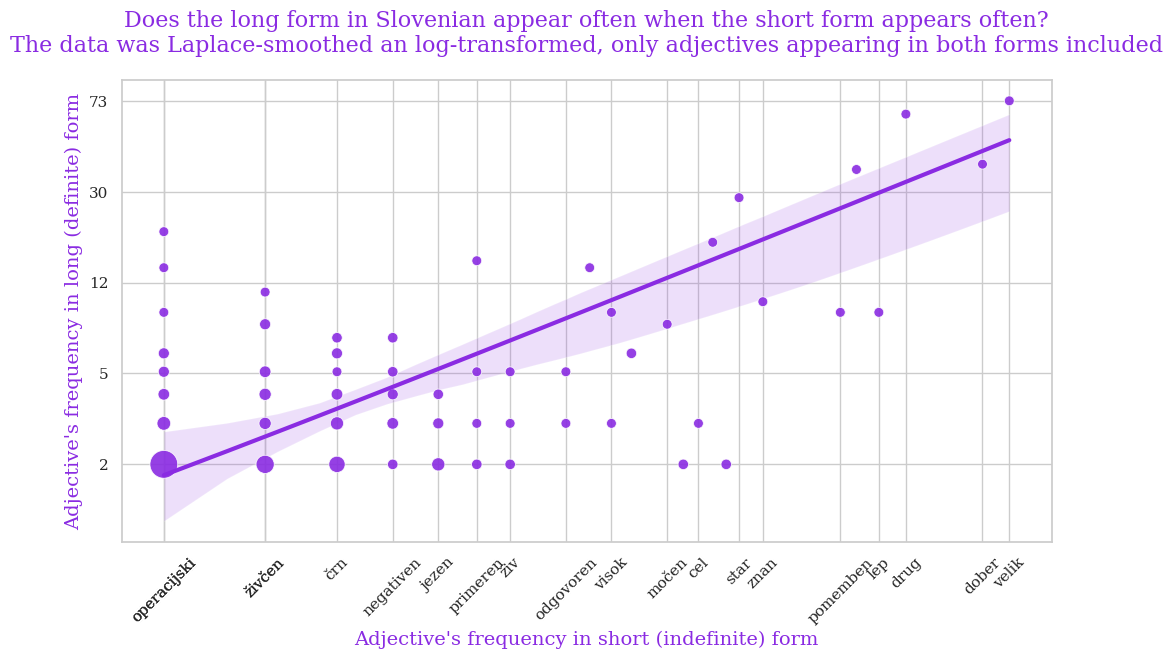

In [ ]:
slov_title = '''Does the long form in Slovenian appear often when the short form appears often?
The data was Laplace-smoothed an log-transformed, only adjectives appearing in both forms included'''
sl = plot_adjective_comparison(df_slov, title=slov_title,
                          xlabel='Adjective\'s frequency in short (indefinite) form',
                          ylabel='Adjective\'s frequency in long (definite) form')

In [ ]:
df_rus = get_language_adj_frequencies(('Russian'), short_tokens, all_tokens, long_condition=lambda x: not x.get('Variant'))

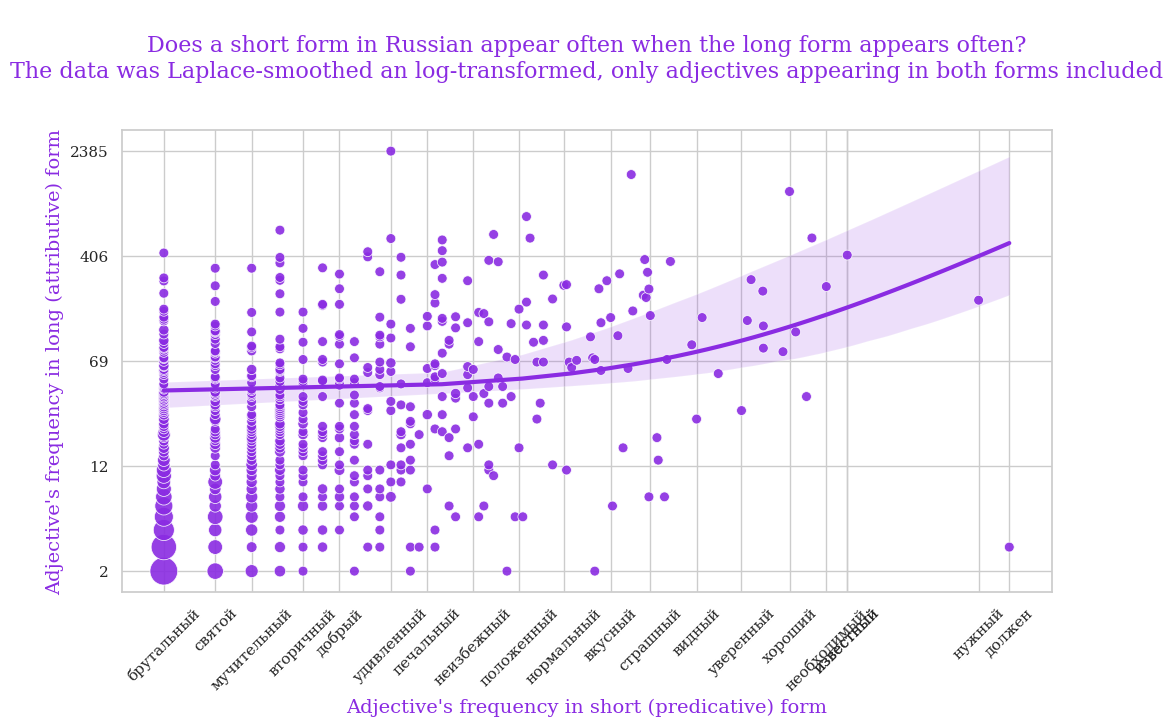

In [ ]:
rus_title = '''
Does a short form in Russian appear often when the long form appears often?
The data was Laplace-smoothed an log-transformed, only adjectives appearing in both forms included
'''
_ = plot_adjective_comparison(df_rus, title=rus_title,
                          xlabel='Adjective\'s frequency in short (predicative) form',
                          ylabel='Adjective\'s frequency in long (attributive) form')

In [ ]:
# now for all short adjectives in Czech
df_cz = get_language_adj_frequencies(('Czech'), short_tokens, all_tokens, long_condition=lambda x: not x.get('Variant'))

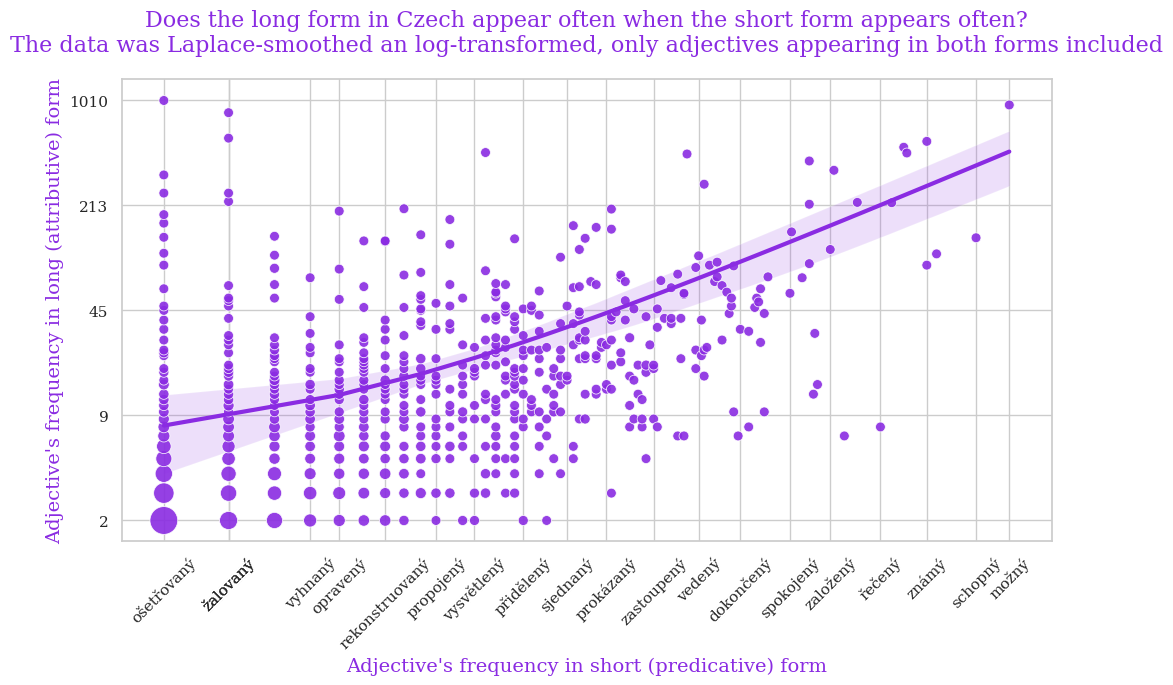

In [ ]:
czech_title = '''Does the long form in Czech appear often when the short form appears often?
The data was Laplace-smoothed an log-transformed, only adjectives appearing in both forms included'''
cz = plot_adjective_comparison(df_cz, title=czech_title,
                          xlabel='Adjective\'s frequency in short (predicative) form',
                          ylabel='Adjective\'s frequency in long (attributive) form')

In [ ]:
# Let's compare most frequent masculine adjectives for Serbo-Croatian
df_sc = get_language_adj_frequencies(('Serbian', 'Croatian'), short_tokens, all_tokens)

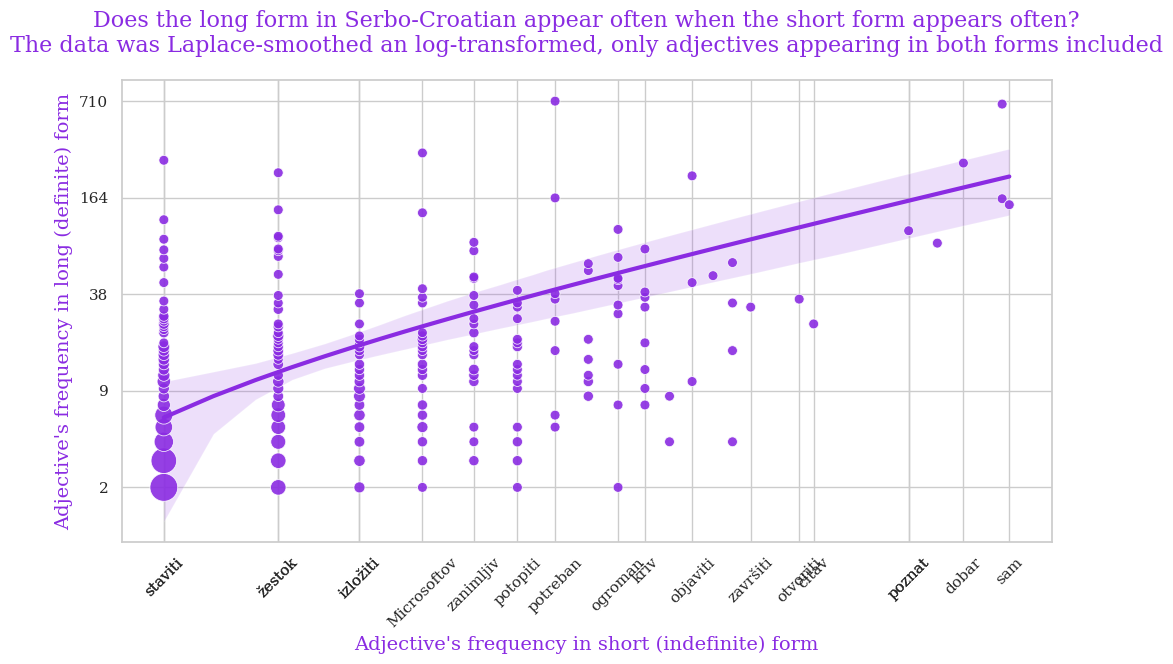

In [ ]:
sc_title = '''Does the long form in Serbo-Croatian appear often when the short form appears often?
The data was Laplace-smoothed an log-transformed, only adjectives appearing in both forms included'''
sc = plot_adjective_comparison(df_sc, title=sc_title,
                          xlabel='Adjective\'s frequency in short (indefinite) form',
                          ylabel='Adjective\'s frequency in long (definite) form')

                            OLS Regression Results                            
Dep. Variable:               log_long   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     376.0
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           3.44e-72
Time:                        20:46:32   Log-Likelihood:                -1777.1
No. Observations:                1092   AIC:                             3558.
Df Residuals:                    1090   BIC:                             3568.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6160      0.065     24.919      0.0

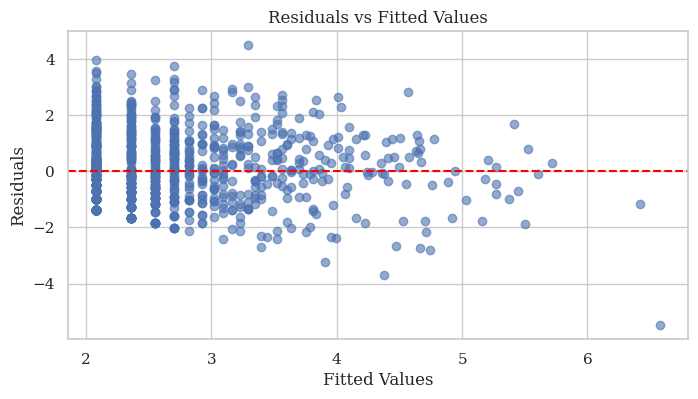

In [ ]:
# CONCLUSION FOR THIS PART
# for that let's compare how correlated are two log freuqencies
# this requires analyzing how close to the power law distribution is this graph
# let's fit a log log regression to check that and see the R2
df_rus['log_short'] = np.log(df_rus['short_count'])
df_rus['log_long'] = np.log(df_rus['long_count'])

X = sm.add_constant(df_rus['log_short'])
y = df_rus['log_long']

model = sm.OLS(y, X).fit()

print(model.summary())

plt.figure(figsize=(8, 4))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [ ]:
# The residuals are the least normally distributed for Czech, however the residuals are significantly not normal everywhere.
# Czech and Slovene have the highest R2 (0.35, 0.3 correspondingly). Russian has the lowest R2 (0.2). This is a sign that
# some other factors greatly affect the frequency of short adjectives in Russian than the frequency of the unmarked form.
# There are forms like необходим, известен, важен etc. that mostly appear in the short form (often it is the "category of state"
# function however). In Slovene there are no such outliers. In Czech, despite great variation, the impact of frequency is greater.

In [ ]:
# PREREQUISITE FOR ASSESSING THE PRODUCTIVITY
# vocabulary growing curves for short adjectives in the large sample languages

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1dyAxgxQkabKeb8UP0iTc_TiGBwWFuZ1K/datsci2025_short_adjectives/rawdata/bancae arborerum/bancae arborerum'

In [ ]:
os.chdir('..')

In [ ]:
# test for russian
russiancorpora = '''ru_syntagrus-ud-dev.conllu ru_syntagrus-ud-test.conllu ru_syntagrus-ud-train.conllu ru_gsd-ud-dev.conllu ru_gsd-ud-test.conllu ru_gsd-ud-train.conllu ru_taiga-ud-test.conllu ru_taiga-ud-dev.conllu ru_taiga-ud-train.conllu ru_pud-ud-test.conllu'''.split()
rus_corpus = []
for l, c in langs_pd:
    if l == "Russian":
        os.chdir(c)
        for fi in os.listdir():
            if fi in russiancorpora:
                with open(fi, 'r', encoding='utf-8') as f:
                    rus_conllu = conllu.parse(f.read())
                for s in rus_conllu:
                    rus_corpus.extend(s)
        os.chdir('..')


In [ ]:
len(rus_corpus)

1832231

In [ ]:
# baayens vocabulary growth binominally interpolated graph

In [ ]:
rus_freq_spectrum = Counter([t['lemma'] for t in rus_corpus])

In [ ]:
# DATA ANALYSIS
# Function implementing Baayen's formula
def baayen(tokens):
  N = len(tokens) # total number of all tokens in the morphological category
  token_counts = Counter(tokens)
  n1 = sum(1 for count in token_counts.values() if count == 1) # number of hapax legomena
  return n1 / N

In [ ]:
# Function implementing the measurement of the probability of encountering a short adjective given adjective lemma
# def p_short(tokens):
#   lemma_dict = defaultdict(list)
#   for t in tokens:
#     if t['token']['upos'] == 'ADJ':
#       lemma = t['lemma']
#       lemma_dict.append(t)
#       adjs_per_lemma = len(lemma_dict)
#       short_adjs = [a for a in lemma_dict if a['feats'].get('Variant') == 'Short']
#       short_adjs_per_lemma = len(short_adjs)
#   return short_adjs_per_lemma / adjs_per_lemma
def p_short(lemma_dict):
  short_adjs = [a for a in lemma_dict.values() if a['token'].get('feats') and a['token']['feats'].get('Variant') == 'Short' or \
                a['token'].get('feats') and a['token']['feats'].get('Definite') == 'Ind' or \
                a['token']['upos'] == 'ADJ' and a[token]['form'] == 'pewien'.lower()]
  return len(short_adjs) / len(lemma_dict)

In [ ]:
# Function implementing entropy
def is_short_adjective(token):
  if token.get('upos') and token['upos'] == 'ADJ':
    if token.get('feats') and token['feats'].get('Variant') == 'Short':
      return True
    elif token.get('feats') and token['feats'].get('Definite') == 'Ind':
      return True
    elif token['form'] == 'pewien'.lower and token['upos'] == 'ADJ':
      return True
    else:
      return False

def entropy(tokens):
  lemma_counts = defaultdict(lambda: {'short': 0, 'total': 0})

  # Aggregate counts per lemma
  for token in tokens:
    if token.get('upos') != 'ADJ':
      continue
    lemma = token.get('lemma')
    if not lemma:
      continue

    lemma_counts[lemma]['total'] += 1
    if is_short_adjective(token):
      lemma_counts[lemma]['short'] += 1

  # Compute entropy
  entropy_values = []
  for lemma, counts in lemma_counts.items():
    total = counts['total']
    short = counts['short']

    if total == 0 or short == 0 or short == total:
      continue  # Skip if p(short) is 0 or 1 (entropy = 0)

    p_short = short / total
    entropy = -p_short * math.log2(p_short)
    entropy_values.append(entropy)

    # Average entropy across lemmas
  if not entropy_values:
    return 0.0  # Avoid division by zero

  return sum(entropy_values) / len(entropy_values)

def gendered_entropy(tokens):
  pair_counts = defaultdict(lambda: {'short': 0, 'total': 0})

  # Aggregate counts per lemma
  for token in tokens:
    if token.get('upos') != 'ADJ':
      continue
    lemma = token.get('lemma')
    if token.get('feats'):
      gender = token['feats'].get('Gender')
    if not lemma or not gender:
      continue

    key = (lemma, gender)
    pair_counts[key]['total'] += 1
    if is_short_adjective(token):
      pair_counts[key]['short'] += 1

  # Compute entropy
  entropy_values = []
  for (lemma, gender), counts in pair_counts.items():
    total = counts['total']
    short = counts['short']

    if total == 0 or short == 0 or short == total:
      continue  # Skip if p(short) is 0 or 1 (entropy = 0)

    p_short = short / total
    entropy = -p_short * math.log2(p_short)
    entropy_values.append(entropy)

    # Average entropy across lemmas
  if not entropy_values:
    return 0.0  # Avoid division by zero

  return sum(entropy_values) / len(entropy_values)

In [ ]:
langs = list(set(token['language'] for token in short_tokens))
print(langs)
corpora = list(set(token['corpus'] for token in short_tokens))
print(corpora)
langs_and_corpora = list(set((token['language'], token['corpus']) for token in short_tokens))
print(langs_and_corpora)

['Slovenian', 'Czech', 'Ukrainian', 'Serbian', 'Croatian', 'Belarusian', 'Polish', 'Russian']
['UD_Russian-Taiga', 'UD_Serbian-SET', 'UD_Ukrainian-IU', 'UD_Czech-FicTree', 'UD_Polish-PUD', 'UD_Polish-LFG', 'UD_Slovenian-SSJ', 'UD_Czech-CAC', 'UD_Polish-PDB', 'UD_Czech-PUD', 'UD_Slovenian-SST', 'UD_Russian-GSD', 'UD_Czech-PDT', 'UD_Czech-CLTT', 'UD_Russian-PUD', 'UD_Russian-SynTagRus', 'UD_Ukrainian-ParlaMint', 'UD_Croatian-SET', 'UD_Belarusian-HSE']
[('Polish', 'UD_Polish-LFG'), ('Slovenian', 'UD_Slovenian-SSJ'), ('Czech', 'UD_Czech-FicTree'), ('Czech', 'UD_Czech-CAC'), ('Ukrainian', 'UD_Ukrainian-IU'), ('Czech', 'UD_Czech-PUD'), ('Russian', 'UD_Russian-GSD'), ('Russian', 'UD_Russian-Taiga'), ('Croatian', 'UD_Croatian-SET'), ('Ukrainian', 'UD_Ukrainian-ParlaMint'), ('Polish', 'UD_Polish-PUD'), ('Slovenian', 'UD_Slovenian-SST'), ('Russian', 'UD_Russian-PUD'), ('Polish', 'UD_Polish-PDB'), ('Russian', 'UD_Russian-SynTagRus'), ('Belarusian', 'UD_Belarusian-HSE'), ('Czech', 'UD_Czech-CLTT')

In [ ]:
# Counting productivity per language
df_productivity_per_lang = pd.DataFrame(index=langs, columns=['Short adjectives productivity rank'])
for l in langs:
  lang_short_tokens = [t['form'] for t in short_tokens if t['language'] == l]
  df_productivity_per_lang.loc[l, 'Short adjectives productivity rank'] = baayen(lang_short_tokens)
df_productivity_per_lang.sort_values(by='Short adjectives productivity rank', ascending=False).dropna()

,Short adjectives productivity rank
Serbian,0.416544
Croatian,0.358815
Slovenian,0.316439
Belarusian,0.173913
Czech,0.142135
Russian,0.095697
Ukrainian,0.08
Polish,0.032258


In [ ]:
# Counting productivity per corpus
df_productivity_per_corpus = pd.DataFrame(index=corpora, columns=['Short adjectives productivity rank'])
for c in corpora:
  corp_short_tokens = [t['form'] for t in short_tokens if t['corpus'] == c]
  df_productivity_per_corpus.loc[c, 'Short adjectives productivity rank'] = baayen(corp_short_tokens)
# df_productivity_per_corpus.drop(df_productivity_per_corpus[df_productivity_per_corpus['Short adjectives productivity rank'] == 1.0].index, inplace=True)
df_productivity_per_corpus.sort_values(by='Short adjectives productivity rank', ascending=False).dropna()

,Short adjectives productivity rank
UD_Polish-LFG,1.0
UD_Czech-PUD,0.781818
UD_Russian-PUD,0.524752
UD_Russian-GSD,0.46595
UD_Czech-FicTree,0.460993
UD_Slovenian-SST,0.428894
UD_Serbian-SET,0.416544
UD_Slovenian-SSJ,0.362541
UD_Croatian-SET,0.358815
UD_Polish-PUD,0.333333


In [ ]:
# Counting entropy per language
df_entropy_per_lang = pd.DataFrame(index=langs, columns=['Short adjectives entropy'])
for l in langs:
  language_tokens = [a['token'] for a in all_tokens if a['language'] == l]
  # print(language_tokens)
  df_entropy_per_lang.loc[l, 'Short adjectives entropy'] = entropy(language_tokens)
df_entropy_per_lang.sort_values(by='Short adjectives entropy', ascending=False)

,Short adjectives entropy
Croatian,0.446982
Serbian,0.445774
Slovenian,0.430088
Czech,0.426986
Russian,0.387475
Belarusian,0.382451
Polish,0.382195
Ukrainian,0.37284


In [ ]:
# Counting entropy per corpus
df_entropy_per_corpus = pd.DataFrame(index=corpora, columns=['Short adjectives entropy'])
for c in corpora:
  corp_tokens = [a['token'] for a in all_tokens if a['corpus'] == c]
  df_entropy_per_corpus.loc[c, 'Short adjectives entropy'] = entropy(corp_tokens)
df_entropy_per_corpus.sort_values(by='Short adjectives entropy', ascending=False)

,Short adjectives entropy
UD_Czech-PUD,0.466095
UD_Russian-PUD,0.459097
UD_Russian-GSD,0.45731
UD_Czech-FicTree,0.452716
UD_Croatian-SET,0.446982
UD_Serbian-SET,0.445774
UD_Slovenian-SST,0.444979
UD_Czech-CAC,0.44074
UD_Slovenian-SSJ,0.430822
UD_Czech-PDT,0.424811


In [ ]:
# Counting gendered entropy per language
df_gendered_entropy_per_lang = pd.DataFrame(index=langs, columns=['Short adjectives gendered entropy'])
for l in langs:
  language_tokens = [a['token'] for a in all_tokens if a['language'] == l]
  # print(language_tokens)
  df_gendered_entropy_per_lang.loc[l, 'Short adjectives gendered entropy'] = gendered_entropy(language_tokens)
df_gendered_entropy_per_lang.sort_values(by='Short adjectives gendered entropy', ascending=False)

,Short adjectives gendered entropy
Slovenian,0.46578
Croatian,0.455164
Serbian,0.450772
Czech,0.425421
Russian,0.40032
Belarusian,0.398922
Ukrainian,0.367358
Polish,0.0


In [ ]:
# Counting gendered entropy per corpus
df_gendered_entropy_per_corpus = pd.DataFrame(index=corpora, columns=['Short adjectives gendered entropy'])
for c in corpora:
  corp_tokens = [a['token'] for a in all_tokens if a['corpus'] == c]
  df_gendered_entropy_per_corpus.loc[c, 'Short adjectives gendered entropy'] = gendered_entropy(corp_tokens)
df_gendered_entropy_per_corpus.sort_values(by='Short adjectives gendered entropy', ascending=False)

,Short adjectives gendered entropy
UD_Ukrainian-IU,0.50944
UD_Russian-PUD,0.491103
UD_Slovenian-SSJ,0.463085
UD_Slovenian-SST,0.456689
UD_Croatian-SET,0.455164
UD_Serbian-SET,0.450772
UD_Czech-FicTree,0.44804
UD_Czech-PUD,0.444167
UD_Russian-GSD,0.443245
UD_Czech-CAC,0.439493


In [ ]:
for lang, corpus in langs_and_corpora:
  corp_tokens_entropy = [a['token'] for a in all_tokens if a['corpus'] == corpus]
  df_UDreview.loc[(lang, corpus), 'num_adjectives'] = len(corp_tokens_entropy)
  corp_tokens_productivity = [t['form'] for t in short_tokens if t['corpus'] == corpus]
  df_UDreview.loc[(lang, corpus), 'num_short_adjectives'] = len(corp_tokens_productivity)
  df_UDreview.loc[(lang, corpus), 'short_adjectives_productivity_rank'] = baayen(corp_tokens_productivity)
  df_UDreview.loc[(lang, corpus), 'short_adjectives_entropy'] = entropy(corp_tokens_entropy)
df_UDreview.sort_values(by='short_adjectives_productivity_rank', ascending=False)

num_sentences num_tokens  num_adjectives  \
language   corpus                                                            
Polish     UD_Polish-LFG                  17246     130967          8586.0   
Czech      UD_Czech-PUD                    8874     193817          2265.0   
Russian    UD_Russian-PUD                 17991     206082          1879.0   
           UD_Russian-GSD                  5030      97994         12268.0   
Czech      UD_Czech-FicTree               12760     167850         10907.0   
Slovenian  UD_Slovenian-SST                6108      98393          5272.0   
Serbian    UD_Serbian-SET                  4384      97673         11652.0   
Slovenian  UD_Slovenian-SSJ               13435     267097         28426.0   
Croatian   UD_Croatian-SET                 9010     199409         24105.0   
Polish     UD_Polish-PUD                  25081     503809          2361.0   
Czech      UD_Czech-CLTT                   1121      36039          6643.0   
           UD_Czech-CAC                   24709     496296         74313.0   
Ukrainian  UD_Ukrainian-ParlaMint          3433      51997          5054.0   
Russian    UD_Russian-Taiga               17872     197001         16788.0   
Ukrainian  UD_Ukrainian-IU                 7092     123032         11912.0   
Czech      UD_Czech-PDT                   87907    1531825        185364.0   
Belarusian UD_Belarusian-HSE              25231     305417         23642.0   
Russian    UD_Russian-SynTagRus           87336    1517881        144221.0   
Polish     UD_Polish-PDB                  22152     352473         35928.0   
Czech      UD_Czech-Poetry                    0          0             NaN   
Russian    UD_Russian-Poetry                  0          0             NaN   

                                   num_short_adjectives  \
language   corpus                                         
Polish     UD_Polish-LFG                            1.0   
Czech      UD_Czech-PUD                           220.0   
Russian    UD_Russian-PUD                         101.0   
           UD_Russian-GSD                         279.0   
Czech      UD_Czech-FicTree                       564.0   
Slovenian  UD_Slovenian-SST                       443.0   
Serbian    UD_Serbian-SET                         677.0   
Slovenian  UD_Slovenian-SSJ                      1826.0   
Croatian   UD_Croatian-SET                       1452.0   
Polish     UD_Polish-PUD                            3.0   
Czech      UD_Czech-CLTT                          357.0   
           UD_Czech-CAC                          5144.0   
Ukrainian  UD_Ukrainian-ParlaMint                   9.0   
Russian    UD_Russian-Taiga                      2362.0   
Ukrainian  UD_Ukrainian-IU                         16.0   
Czech      UD_Czech-PDT                         11128.0   
Belarusian UD_Belarusian-HSE                      690.0   
Russian    UD_Russian-SynTagRus                 12316.0   
Polish     UD_Polish-PDB                           27.0   
Czech      UD_Czech-Poetry                          NaN   
Russian    UD_Russian-Poetry                        NaN   

                                   short_adjectives_productivity_rank  \
language   corpus                                                       
Polish     UD_Polish-LFG                                     1.000000   
Czech      UD_Czech-PUD                                      0.781818   
Russian    UD_Russian-PUD                                    0.524752   
           UD_Russian-GSD                                    0.465950   
Czech      UD_Czech-FicTree                                  0.460993   
Slovenian  UD_Slovenian-SST                                  0.428894   
Serbian    UD_Serbian-SET                                    0.416544   
Slovenian  UD_Slovenian-SSJ                                  0.362541   
Croatian   UD_Croatian-SET                                   0.358815   
Polish     UD_Polish-PUD                                     0.333333   
Czech

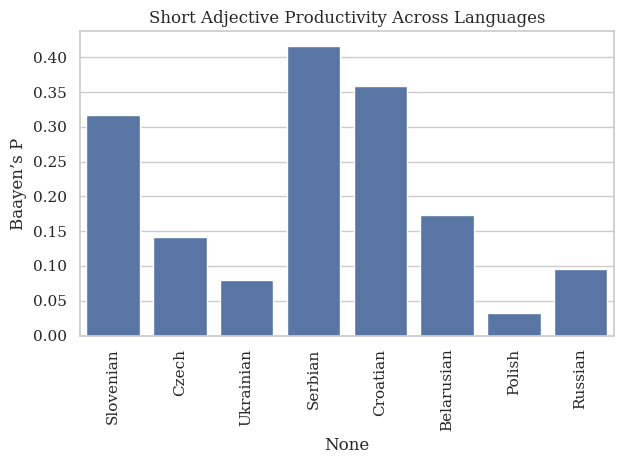

In [ ]:
# hypothesis testing - productivity plot
sns.barplot(x=df_productivity_per_lang.index, y='Short adjectives productivity rank', data=df_productivity_per_lang)
plt.xticks(rotation=90)
plt.title("Short Adjective Productivity Across Languages")
plt.ylabel("Baayen’s P")
plt.tight_layout()
plt.show()

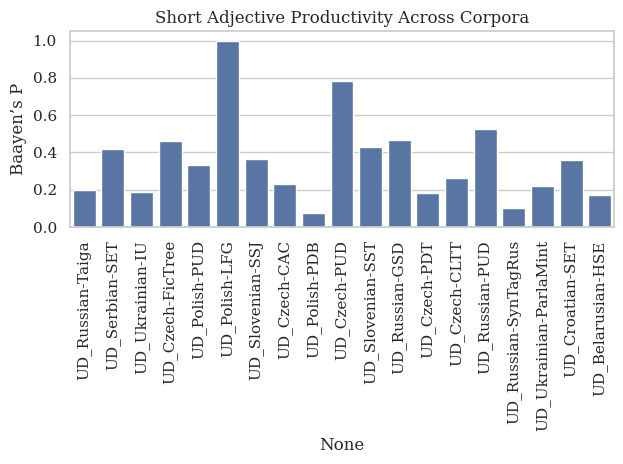

In [ ]:
# hypothesis testing - productivity plot
sns.barplot(x=df_productivity_per_corpus.index, y='Short adjectives productivity rank', data=df_productivity_per_corpus)
plt.xticks(rotation=90)
plt.title("Short Adjective Productivity Across Corpora")
plt.ylabel("Baayen’s P")
plt.tight_layout()
plt.show()

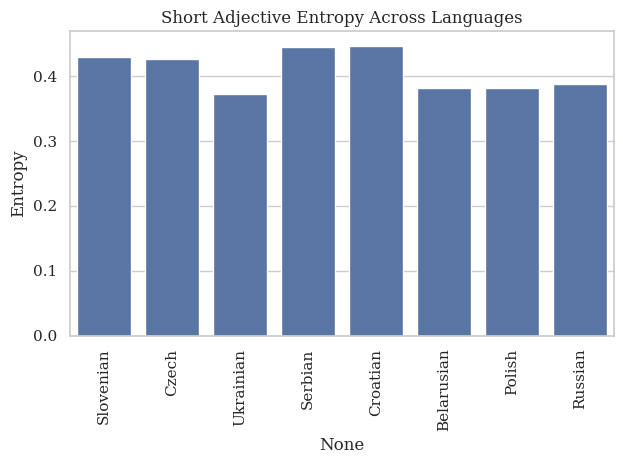

In [ ]:
# hypothesis testing - entropy plot
sns.barplot(x=df_entropy_per_lang.index, y='Short adjectives entropy', data=df_entropy_per_lang)
plt.xticks(rotation=90)
plt.title("Short Adjective Entropy Across Languages")
plt.ylabel("Entropy")
plt.tight_layout()
plt.show()

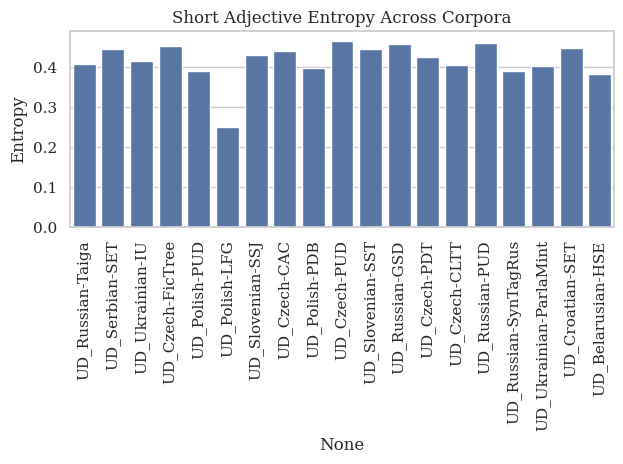

In [ ]:
# hypothesis testing - productivity plot
sns.barplot(x=df_entropy_per_corpus.index, y='Short adjectives entropy', data=df_entropy_per_corpus)
plt.xticks(rotation=90)
plt.title("Short Adjective Entropy Across Corpora")
plt.ylabel("Entropy")
plt.tight_layout()
plt.show()

In [ ]:
# hypothesis testing
# Null hypothesis I: productivity of short forms doesn't differ across Slavic languages
# Null hypothesis II: morphosyntactic features have no influence over the adjective form

In [ ]:
# Testing null hypothesis I
df_proportion_matrix = pd.DataFrame(index=langs, columns=['num_short_adjectives_as_hapax_legomena', 'total_num_short_adjectives'])
for l in langs:
  lemma_counts = Counter([t['lemma'] for t in short_tokens if t['language'] == l])
  num_hapax = sum(1 for lemma, count in lemma_counts.items() if count == 1)
  df_proportion_matrix.loc[l, 'num_short_adjectives_as_hapax_legomena'] = num_hapax
  df_proportion_matrix.loc[l, 'total_num_short_adjectives'] = len([t['token'] for t in short_tokens if t['language'] == l])
df_proportion_matrix['num_short_adjectives_non_hapax_legomena'] = df_proportion_matrix['total_num_short_adjectives'] - df_proportion_matrix['num_short_adjectives_as_hapax_legomena']
df_proportion_matrix

,num_short_adjectives_as_hapax_legomena,total_num_short_adjectives,num_short_adjectives_non_hapax_legomena
Slovenian,649,2269,1620
Czech,884,17413,16529
Ukrainian,2,25,23
Serbian,262,677,415
Croatian,480,1452,972
Belarusian,99,690,591
Polish,1,31,30
Russian,584,15058,14474


In [ ]:
# Testing null hypothesis I
df_proportion_matrix['num_short_adjectives_as_hapax_legomena'] = df_proportion_matrix['num_short_adjectives_as_hapax_legomena'].astype(int)
df_proportion_matrix['num_short_adjectives_non_hapax_legomena'] = df_proportion_matrix['num_short_adjectives_non_hapax_legomena'].astype(int)
contingency_table = df_proportion_matrix[['num_short_adjectives_as_hapax_legomena', 'num_short_adjectives_non_hapax_legomena']].values
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected:\n{expected}")

Chi-squared statistic: 4061.431048066003
P-value: 0.0
Degrees of freedom: 7
Expected:
[[1.78612495e+02 2.09038750e+03]
 [1.37072692e+03 1.60422731e+04]
 [1.96796491e+00 2.30320351e+01]
 [5.32924897e+01 6.23707510e+02]
 [1.14299402e+02 1.33770060e+03]
 [5.43158315e+01 6.35684169e+02]
 [2.44027649e+00 2.85597235e+01]
 [1.18534462e+03 1.38726554e+04]]


P-value is below 0.05, the null hypothesis is rejected.

In [ ]:
# Preprocessing for Logistic Regression

In [ ]:
lang_dfs = defaultdict(list)

for i, token in enumerate(all_tokens):
    lang = token.get('language')
    if lang not in langs:
        continue

    t = token['token']
    form = t['form']
    lemma = t['lemma']
    token_id = t['id']
    # head_id = token.get('head')
    deprel = t.get('deprel')
    gender = t.get('feats', {}).get('Gender')
    definiteness = t.get('feats', {}).get('Definite')

    form_type = 'short' if t.get('feats') and t['feats'].get('Variant') == 'Short' or t['feats'].get('Definite') == 'Ind' or t['upos'] == 'ADJ' and t['form'] == 'pewien'.lower()  else 'long'
    # head_lemma = None
    # for candidate in all_tokens:
    #   if (candidate['language'] == lang and
    #     candidate['token'].get('id') == head_id and
    #     candidate.get('sentence_metadata') == token.get('sentence_metadata')):
    #     head_lemma = candidate['token'].get('lemma')
    #     break

    preceding = all_tokens[i - 1]['token']['form'] if i > 0 and all_tokens[i - 1]['language'] == lang else None
    following = all_tokens[i + 1]['token']['form'] if i < len(all_tokens) - 1 and all_tokens[i + 1]['language'] == lang else None

    row = {
        'form': form,
        'lemma': lemma,
        'form_type': form_type,
        # 'head': head_lemma,
        'deprel': deprel,
        'gender': gender,
        # 'id': token_id,
        # 'preceding_token': preceding,
        # 'following_token': following
    }
    if definiteness:
      row['definiteness'] = definiteness
    # print(row)
    lang_dfs[lang].append(row)

lang_dataframes = {
    lang: pd.DataFrame(rows).set_index('form')
    for lang, rows in lang_dfs.items()
}

In [ ]:
# TEST: Displaying dataframe

In [ ]:
for language, dataframe in lang_dataframes.items():
  print(f"\n Language: {language}")
  X = dataframe.drop(columns=['form_type'])
  y = dataframe['form_type']
  preprocessor = sklearn.compose.ColumnTransformer([('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore'), X.columns)])
  model = sklearn.pipeline.make_pipeline(preprocessor, sklearn.linear_model.LogisticRegression(max_iter=1000))
  model.fit(X, y)

  coefs = model.named_steps['logisticregression'].coef_[0]
  feature_names = model.named_steps['columntransformer'].get_feature_names_out()
  important_features = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)

  for feat, weight in important_features[:10]:
    print(f"{feat}: {weight:.3f}")


 Language: Belarusian
cat__lemma_павінны: 5.929
cat__deprel_amod: -4.665
cat__lemma_годны: 3.228
cat__lemma_вольны: 2.901
cat__gender_Neut: 2.745
cat__lemma_галоўны: -2.535
cat__lemma_вядомы: 2.127
cat__lemma_магчымы: 2.107
cat__lemma_цяжкі: 1.997
cat__deprel_obj: -1.843

 Language: Croatian
cat__definiteness_Ind: 6.739
cat__definiteness_Def: -5.532
cat__definiteness_nan: -2.821
cat__gender_Fem: -1.117
cat__gender_None: -1.059
cat__deprel_amod: -1.042
cat__gender_Masc: 0.944
cat__lemma_drugi: -0.786
cat__lemma_prvi: -0.603
cat__gender_Neut: -0.381

 Language: Czech
cat__gender_None: -8.172
cat__gender_Fem,Neut: 6.735
cat__gender_Fem,Masc: 6.419
cat__lemma_rád: 5.915
cat__lemma_považovaný: 4.824
cat__gender_Fem: -4.445
cat__lemma_nucený: 4.226
cat__lemma_pověřený: 4.006
cat__lemma_předaný: 3.969
cat__lemma_stíhaný: 3.965

 Language: Polish
cat__lemma_pewny: 5.562
cat__gender_None: 3.188
cat__gender_Fem: -3.116
cat__lemma_gotowy: 2.947
cat__deprel_amod: -2.734
cat__gender_Neut: -2.693
c

As visible in the output, in South Slavic languages, the choice of the form is mostly dictated by its definiteness (indefinite - short, definite - long). In Russian it is mostly predicted by dependency relation (root suggesting its being predicative position dictating the choice of the short form), so it is in Czech, Belarusian, and Ukrainian, but in the latter two languages, the gender is also an important predictor: for Ukrainian it is masculine; for Belarusian neuter. Polish, Ukrainian and Belarusian seem to have a limited group of adjectives that tend to have short forms in predicative positions. In Czech the adjectives occurring in short forms the most are passive participles.